In [65]:
# This version is a result of joint work with Dmitry Pasechnyuk (MIPT, https://github.com/dmivilensky)

# A new dataset: http://archive.ics.uci.edu/ml/datasets/gas+sensors+for+home+activity+monitoring

import numpy as np
import math
from scipy.optimize import minimize  
import time

# Oracle Complexity Separation

##### Katyusha
https://arxiv.org/pdf/1603.05953.pdf

In [66]:
def orac_psi_kat(x, ksik, ksi0, p_grad_h, L, Lh):
    nor1 = np.linalg.norm(x - ksik, 2)
    nor_sq1 = nor1*nor1

    nor2 = np.linalg.norm(x - ksi0, 2)
    nor_sq2 = nor2*nor2
    
    return float(np.dot(p_grad_h(ksik).T, x - ksik)) + Lh / 2 * nor_sq1 + L / 2 * nor_sq2

In [67]:
def orac_z(x, alpha, p_orac_psi_kat, zk, gr_tilde, ksik, ksi0, p_grad_h, L, Lh):
    
    nor1 = np.linalg.norm(x - zk, 2)
    nor_sq1 = nor1*nor1

    return 1 / 2 / alpha * nor_sq1  + float(np.dot(gr_tilde.T, x)) + p_orac_psi_kat(x, ksik, ksi0, p_grad_h, L, Lh)

In [68]:
def argmin_sol(x, alpha, p_orac_psi_kat, zk, gr_tilde, ksik, ksi0, p_grad_h, L, Lh):
    return (1 / alpha * zk - gr_tilde + Lh * ksik + L * ksi0 - p_grad_h(ksik)) / (1 / alpha + Lh + L)

In [69]:
def Katyusha(x0, S_n, L, p_grad_h, p_grad_g, p_stoch_grad, p_orac_z, eps, p_h, Lh, ksik, ksi0, p_orac_psi_kat):
    n_dim = x0.shape[0]
    n_sam = n_dim - 1
    m = 3 # 2 * n_sam
    tau2 = 0.5
    n = n_sam
 
    y = np.copy(x0)
    z = np.copy(x0)
    x_tilde = np.copy(x0)
    
    num_grad_g_stoch_calls = 0
    
    for i in range(0, S_n):
        grad_mu = p_grad_g(x_tilde)
        num_grad_g_stoch_calls = num_grad_g_stoch_calls + n_sam
        tau1 = 2 / (i + 4)
        
        alpha = 1 / 3 / tau1 / L
        
        sum_y = 0
        
        for j in range(0, m):
            k = s * m + j
            x = tau1 * z + tau2 * x_tilde + (1 - tau1 - tau2) * y
            a = np.random.randint(0, n_sam) 
            grad_x = p_stoch_grad(x, a)
            grad_x_tilde = p_stoch_grad(x_tilde, a)
            num_grad_g_stoch_calls = num_grad_g_stoch_calls + 2
            
            grad_t = grad_mu + grad_x - grad_x_tilde
            z_new = np.copy(z)
            
            
            # allargs = (alpha, p_orac_psi_kat, z, grad_t, ksik, ksi0, p_grad_h, L, Lh)
            # minim_res = minimize(p_orac_z, args = allargs, x0 = np.ravel(z), tol = eps, options={'maxiter': 15, 'disp': False})

            minim_res2 = argmin_sol(z_new, alpha, p_orac_psi_kat, z, grad_t, ksik, ksi0, p_grad_h, L, Lh)
            
            # print("Norm", np.linalg.norm(minim_res.x - minim_res2))

            #print('j inside Kat', j)
            z_new = minim_res2
            y = x + tau1 * (z_new - z)
            z = z_new
            
            sum_y = sum_y + y
        x_tilde = 1 / m * sum_y    
    return x_tilde, num_grad_g_stoch_calls

##### Gradient Method for Composite Optimization
 

$\phi_{i}(y) := \langle \nabla h(y^{k}), \, y - y^{k} \rangle + g(y) + \tfrac{L_h}{2} \|y - y^{k}\|_2^2 + \tfrac{L}{2} \|y - y^{0}\|_2^2$

In [70]:
# Psi function
# Input parameters:
# p_grad_h --- pointer on \nabla h(x) function
# p_g --- pointer on \tilde g(x) function
# yk --- y^{k}
# L_h  --- Lipchitz for h(x)

def orac_psi(x, p_grad_h, p_g, Lh, yk, L, y0):
    
    nor1 = np.linalg.norm(x - yk, 2)
    nor_sq1 = nor1*nor1

    nor2 = np.linalg.norm(x - y0, 2)
    nor_sq2 = nor2*nor2
    
    return float(np.dot(p_grad_h(yk).T, x - yk)) + p_g(x) + Lh / 2 * nor_sq1 + L / 2 * nor_sq2


# Gradient Method for Composite Optimization
# Input parameters:
# p_orac_psi --- oracle for Minimization Alg
# p_grad_h --- pointer on \nabla h(x) function
# p_g --- pointer on \tilde g(x) function
# y0 --- y^0 (first initial point for minimize)
# L_h  --- Lipchitz for h(x)
# N --- number of iterations
# xk1 --- $x^{k+1}$

def GradComposite(p_orac_psi, p_grad_h, p_g, Lh, y0, N, L, xk1, p_grad_g, eps, p_stoch_grad, p_h, p_orac_psi_kat):
    
    yi = np.copy(xk1)
    
    # nor1_krit = np.linalg.norm(p_grad_g(yi) + p_grad_h(yi), 2)
    # nor2_krit = 0
    
    i = 0
    
    sum_calls = 0 

    # if nor1_krit <= L / 2 * nor2_krit:
     # return yi, sum_calls
    
    # while True: 
    while True:
        
        i = i + 1
        
        allargs = (p_grad_h, p_g, Lh, yi, L, y0)
        
        #print('minimize start', yi.shape, y0.shape)
        yi, calls = Katyusha(yi, 1, L, p_grad_h, p_grad_g, p_stoch_grad, orac_z, eps, p_h, Lh, yi, y0, p_orac_psi_kat)
        sum_calls = sum_calls + calls
        
        # nor1_krit = np.linalg.norm(p_grad_g(yi) + p_grad_h(yi) + L*(yi - y0), 2)
        # nor2_krit = np.linalg.norm(yi - y0, 2)
        #print('Comp', i, nor1_krit)  
       
        # if nor1_krit <= L / 2 * nor2_krit:
          #  print("BREAK")
           # break
        
        if i > 0:
            break
    
    return yi, sum_calls

#### Monteiro–Svaiter Accelerated Proximal method
Parameters:  
$L > 0$    
$x0$ --- initial point  
$N$ --- number of iterations  
$type\_z\_step$ --- 1 -- stardard version for calculating $z$, 2 -- experimental version for calculating $z$ (without gradient of $f(x)$)   

In [71]:
def ms_acc_prox_method(L, Lh, x0, N, p_grad_h, p_g, p_grad_g, p_f, type_z_step, eps, p_stoch_grad, p_h, verbose = 0, time_scale = False):

    # Initial points
    y0 = np.copy(x0)
    z0 = np.copy(x0)

    it = 0

    x = x0
    y = y0
    z = z0

    plt1 = []
    
    Ak = 0
    
    times = []
    
    time_start = time.time()
    
    calls = []
    
    while  it < N: 
        it = it + 1
        
        ak = (1/L + math.sqrt(1/L/L + 4 * Ak / L)) / 2
        Ak1 = Ak + ak
        
        x = Ak / Ak1 * y + ak / Ak1 * z
        
        #print('mm', x.shape, y.shape, z.shape)
        y, co = GradComposite(orac_psi, p_grad_h, p_g, Lh, x, N, L, x, p_grad_g, eps, p_stoch_grad, p_h, orac_psi_kat)
                
        if type_z_step == 1:
            z = z - ak * (p_grad_h(y) + p_grad_g(y))
            co += y.shape[0] - 1
        elif type_z_step == 2:    
            z = z - ak * L * (x - y)
        
        if verbose == 1:
            print("x y z ak Ak Ak+1", x.shape, y.shape, z.shape, ak, Ak, Ak1)
        
        Ak = Ak1
     

        time_end = time.time() - time_start
        if time_scale:
            times.append(time_end)
            
        if verbose == 1:
            print('Main loop: iter f(y)')
        
        fy = p_f(y)
        plt1.append(fy)
        
        calls.append(co)
        
        if verbose == 1:
            print(it, fy)
        
    return N, y, plt1, times, calls

##### Restarts for MS

In [72]:
def ms_restarts(mu, L, Lh, eta0, N, p_grad_h, p_g, p_grad_g, p_f, type_z_step, verbose = 0):
    
    N1, y1, plt1 = ms_acc_prox_method(L, Lh, x0, N, grad_h1, g1, grad_g1, f1, 1, verbose = 1)
    

#### Case 1. Kernel SVM

In [73]:
import pandas as pd

bcdf = pd.read_csv('HT_Sensor_dataset.dat', names=["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l"], sep='  ', header =1)
ansb = pd.read_csv('HT_Sensor_metadata.dat', sep='\t', names=[0], header = 0, usecols=[2])

ansb[ansb == 'banana'] = 1
ansb[ansb == 'wine'] = -1
ansb[ansb == 'background'] = None

ansb = ansb.dropna().apply(pd.to_numeric, errors = 'ignore')

bcdf = bcdf.drop(bcdf[bcdf.a > ansb.index[-1]].index)
bcdf = bcdf.sample(frac=1, random_state=1).reset_index(drop=True)
bcdf = bcdf[bcdf.index < 4_000]

ansb = ansb.iloc[bcdf.a.tolist()]
ansb.index = pd.RangeIndex(0, ansb.shape[0])
bcdf = bcdf.drop(columns=["a"])

print(bcdf.size)
# bcdf.replace('?', np.nan, inplace = True)
# bcdf.dropna(inplace = True)
print(bcdf.shape)

# bcdf[10].replace(2, 1, inplace = True)
# bcdf[10].replace(4, -1, inplace = True)

bcdf.columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
bcdf = bcdf.apply(pd.to_numeric, errors = 'ignore')
bcdf.info()

<ipython-input-73-0173ef865927>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  bcdf = pd.read_csv('HT_Sensor_dataset.dat', names=["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l"], sep='  ', header =1)


44000
(4000, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4000 non-null   float64
 1   1       4000 non-null   float64
 2   2       4000 non-null   float64
 3   3       4000 non-null   float64
 4   4       4000 non-null   float64
 5   5       4000 non-null   float64
 6   6       4000 non-null   float64
 7   7       4000 non-null   float64
 8   8       4000 non-null   float64
 9   9       4000 non-null   float64
 10  10      4000 non-null   float64
dtypes: float64(11)
memory usage: 375.0 KB


In [74]:
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import pandas as pd
from sklearn import preprocessing

X_val = bcdf.values
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X_val)
x_scaled = min_max_scaler.transform(X_val)
bcdf = pd.DataFrame(x_scaled)

# Split data into testing and training set. Use 67% for training
X_train, X_test, y_train, y_test = train_test_split(bcdf.iloc[:,:], bcdf[10], train_size = .67)

# Transform both training and testing sets

# SVM_params = {'C':[0.001, 0.1, 10, 100], 'kernel':['rbf' ,'linear', 'poly', 'sigmoid']}

# kfold = KFold(n_splits = 5, shuffle = True)#, random_state = 42)

# model_grid = GridSearchCV(SVC(), SVM_params)

# cv_results = cross_val_score(model_grid, X_train_norm, y_train, cv = kfold, scoring = 'accuracy')

# msg = "Cross Validation Accuracy %s: Accuracy: %f SD: %f" % ('SVM sklearn', cv_results.mean(), cv_results.std())

# print(msg)

$$
\min_{\beta_0, \, \beta} \sum_{i = 1}^n [1 - y_i (\beta_0 + \beta x_i)]_+ + \frac{\lambda}{2} \| \beta \|_2
$$

$$
\min_{\beta_0, \, \theta} L[y, \, K \theta] + \frac{\lambda}{2} \theta^T K \theta
$$

$K$ is $n \times n$ matrix, $K(x, x') = \exp(-\gamma \|x - x' \|^2)$

In [75]:
pd.to_numeric(X_train[6])

1095    0.180820
2758    0.104710
3819    0.142527
288     0.164240
2576    0.102548
          ...   
3355    0.110220
359     0.157040
2963    0.169075
3303    0.098989
2442    0.155800
Name: 6, Length: 2680, dtype: float64

In [77]:
from tqdm import tqdm

In [78]:
# Oracles

# h(x) is strongly convex

lam = 0.1
gamma = 1e1

n_sam = X_train.values.shape[0]
X_arr = X_train.values
y_arr = y_train.values.reshape(n_sam, 1)

def K_func(xi, xj):
    nor = np.linalg.norm(xi - xj, 2)
    return np.exp(-gamma * nor * nor)

K_matrix = np.zeros((n_sam, n_sam))
E_matrix = np.identity(n_sam)
for i in tqdm(range(0, n_sam)):
    for j in range(0, n_sam):
        K_matrix[i][j] = K_func(X_arr[i, :], X_arr[j, :])

def h1(btheta):
    theta = btheta[1:] 
    n_dim = theta.shape[0]
    theta = theta.reshape(n_dim, 1)
    #print('h1', lam / 2 * float(np.dot(theta.T, np.dot(K_matrix, theta))))
    return lam / 2 * float(np.dot(theta.T, np.dot(K_matrix, theta)))

def grad_h1(btheta):
    theta = btheta[1:]
    n_dim = theta.shape[0]
    theta = theta.reshape(n_dim, 1)
    gr = lam*np.dot(K_matrix, theta)
    #print('gr', gr.shape)
    gr0 = np.insert(gr, 0, 0)#, axis = 0)
    #print('gr h1', gr0.shape, np.linalg.norm(gr), gr[3], theta[3])
    return gr0 

def g1(btheta):
    
    theta = btheta[1:]
    n_dim = theta.shape[0]
    beta0 = btheta[0]
    s2 = 0
    for i in range(0, n_dim):
                      
        ty = y_arr[i]*(beta0 + float(np.dot(theta.T, K_matrix[i, :].reshape(n_dim, 1))))
        ty = float(ty)
        
        if ty <= 1 - mu_n:
            pos = 1 - ty - mu_n / 2
        elif ty <= 1:
            pos = (1 - ty) * (1 - ty) / 2 / mu_n
        else:
            pos = 0
        s2 = s2 + pos  
        
    return 1 / n_sam * float(s2)

def grad_g1(btheta):
    
    theta = btheta[1:]
    n_dim = theta.shape[0]
    theta = theta.reshape(n_dim, 1)
    beta0 = btheta[0]
    
    gr = np.zeros(btheta.shape)#.reshape(n_dim, 1)    
    sum_for_beta0 = 0
    sum_for_beta = 0
    for i in range(0, n_dim):
        #print(theta.T.shape, K_matrix[i, :].reshape(n_dim, 1).shape)
        ty = y_arr[i]*(beta0 + float(np.dot(theta.T, K_matrix[i, :].reshape(n_dim, 1))))
        ty = float(ty)
        
        if ty <= 1 - mu_n:
            for_beta0 = float(-y_arr[i])
            for_beta = for_beta0*K_matrix[i, :]
            #print(ty, for_beta0.shape, for_beta.shape)
        elif ty <= 1:
            for_beta0 = 1 / mu_n * float((1 - ty) * (-y_arr[i]))
            for_beta = for_beta0 * K_matrix[i, :]
        else:
            for_beta0 = 0
            for_beta = np.zeros(theta.shape[0])
        
        sum_for_beta0 = sum_for_beta0 + for_beta0
        sum_for_beta = sum_for_beta + for_beta
        #print(i, ty, sum_for_beta0, sum_for_beta.shape, np.linalg.norm(sum_for_beta))
    #print(sum_for_beta0, np.linalg.norm(sum_for_beta))    
    gr[0] = sum_for_beta0
    gr[1:] = sum_for_beta
    
    return 1 / n_sam * gr
    
def f1(x):
    return h1(x) + g1(x)

def grad_f1(x):
    return grad_h1(x) + grad_g1(x)

def stoch_grad(x, a):
    
    theta = x[1:]
    n_dim = theta.shape[0]
    theta = theta.reshape(n_dim, 1)
    beta0 = x[0]
    
    gr = np.zeros(x.shape)#.reshape(n_dim, 1)    
        
    ty = y_arr[a]*(beta0 + float(np.dot(theta.T, K_matrix[a, :].reshape(n_dim, 1))))
    ty = float(ty)
        
    if ty <= 1 - mu_n:
            for_beta0 = float(-y_arr[a])
            for_beta = for_beta0*K_matrix[a, :]
            #print(ty, for_beta0.shape, for_beta.shape)
    elif ty <= 1:
            for_beta0 = 1 / mu_n * float((1 - ty) * (-y_arr[a]))
            for_beta = for_beta0 * K_matrix[a, :]
    else:
            for_beta0 = 0
            for_beta = np.zeros(theta.shape[0])
        
    gr[0] = for_beta0
    gr[1:] = for_beta
    
    return 1 / n_sam * gr        

100%|██████████████████████████████████████████████████████████████████████████████| 2680/2680 [01:59<00:00, 22.48it/s]


In [94]:
eps = 1e-2
mu_n = eps # Parameter for Nesterov's smoothing

def check_L(p_orac):
    L = 1e-20
    step = 2
    for i in range(int(1e6)):
        rn1 = np.random.randint(0, 1e8)
        
        x = -rn1 * np.random.rand(n_sam + 1)
        rn2 = np.random.randint(0, 1e2)
        y = rn2 * np.random.rand(n_sam + 1)
        #print(rn1, rn2, np.linalg.norm(x), np.linalg.norm(y))
        d1 = np.linalg.norm(p_orac(x) - p_orac(y))
        d2 = np.linalg.norm(x - y)
        #print(d1, d2)
        while d1 > L*d2:
                L = step*L
                #print(d1, d2, L)
        break        
    return L            
Lh = check_L(grad_h1)
Lg = check_L(grad_g1)

print('Lh exp ', Lh, 'Lg exp', Lg)

Lh exp  47.22366482869645 Lg exp 2.74877906944e-09


In [163]:
n = 10
x0 = 10*np.random.rand(n_sam + 1)

import scipy
w, v = scipy.linalg.eig(K_matrix)
Lh = lam * (np.max(w).real + 1)

print("Lh = ", Lh)

norm_x0 = np.linalg.norm(x0, 2)
s = sum([np.linalg.norm(X_arr[i], 2) for i in range(0, n_sam)])
norm_opt = min([1 / n_sam / lam*s, math.sqrt(2/lam)])
print(norm_x0)

#T = math.log((norm_x0*norm_x0 + norm_opt*norm_opt + 2*norm_x0*norm_opt) * mu / eps)
#N0 = math.sqrt(8 * L / mu)
#N0

L = Lh / 4

R2 = (norm_x0 - norm_opt)**2
T = math.sqrt(L   / eps)
print("T, R^2, L, Lh", T, R2, L, Lh)

Lh =  46.85671062886516
299.32295221240736
T, R^2, L, Lh 34.22598085843018 86937.00384765962 11.71417765721629 46.85671062886516


In [164]:
N_minn = math.log(1/eps)

N = 200

In [165]:
N1 = N

N1, y1, plt1, times_MS, calls = ms_acc_prox_method(L, Lh, x0, N1, grad_h1, g1, grad_g1, f1, 1, eps, stoch_grad, h1, verbose = 1, time_scale = True)

print('Answer 1: ', N1, f1(y1))

x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 0.08536664111321289 0 0.08536664111321289
Main loop: iter f(y)
1 507471.06745522603
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 0.13812612682659262 0.08536664111321289 0.2234927679398055
Main loop: iter f(y)
2 231169.24588697453
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 0.187254039465568 0.2234927679398055 0.4107468074053735
Main loop: iter f(y)
3 71240.74957800214
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 0.2347404504682828 0.4107468074053735 0.6454872578736564
Main loop: iter f(y)
4 10830.761437196901
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 0.28127281097852413 0.6454872578736564 0.9267600688521804
Main loop: iter f(y)
5 1786.525627523524
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 0.327176308254895 0.9267600688521804 1.2539363771070755
Main loop: iter f(y)
6 3168.2203617242903
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 0.3726321083056147 1.2539363771070755 1.6265684854126903
Main loop: iter f(y)
7 1907.0767141394404
x y z ak Ak Ak+1 (2681,) (2681,) (26

x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 2.762959661775171 86.66244109251548 89.42540075429065
Main loop: iter f(y)
62 6.677628879730542
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 2.805972657280234 89.42540075429065 92.23137341157089
Main loop: iter f(y)
63 6.4482908885304555
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 2.8489805997588715 92.23137341157089 95.08035401132976
Main loop: iter f(y)
64 6.2065112792289705
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 2.891983642329683 95.08035401132976 97.97233765365944
Main loop: iter f(y)
65 5.985679653220292
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 2.9349819312391543 97.97233765365944 100.90731958489859
Main loop: iter f(y)
66 5.808226202906196
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 2.9779756062675293 100.90731958489859 103.88529519116612
Main loop: iter f(y)
67 5.657886233221733
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 3.0209648011051122 103.88529519116612 106.90625999227123
Main loop: iter f(y)
68 5.498874159712764
x y z ak Ak Ak+1 (2681,) (2681

x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 5.295157962667458 323.15512992456223 328.4502878872297
Main loop: iter f(y)
121 1.8033542252305428
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 5.338013311733203 328.4502878872297 333.7883011989629
Main loop: iter f(y)
122 1.7743867373571975
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 5.380867279741098 333.7883011989629 339.169168478704
Main loop: iter f(y)
123 1.7467859032244257
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 5.42371988873212 339.169168478704 344.59288836743616
Main loop: iter f(y)
124 1.7193907682415681
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 5.466571160223103 344.59288836743616 350.05945952765927
Main loop: iter f(y)
125 1.6920397301583754
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 5.509421115223248 350.05945952765927 355.5688806428825
Main loop: iter f(y)
126 1.6653595375697625
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 5.55226977424998 355.5688806428825 361.12115041713247
Main loop: iter f(y)
127 1.6399024777932045
x y z ak Ak Ak+1 (2681,) 

x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 7.864599472599805 716.679836829976 724.5444363025758
Main loop: iter f(y)
181 0.8255039621549766
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 7.907398619298886 724.5444363025758 732.4518349218747
Main loop: iter f(y)
182 0.8176884574265697
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 7.950197139092978 732.4518349218747 740.4020320609677
Main loop: iter f(y)
183 0.8103125732110117
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 7.992995038740737 740.4020320609677 748.3950270997085
Main loop: iter f(y)
184 0.8031503989587566
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 8.035792324892014 748.3950270997085 756.4308194246005
Main loop: iter f(y)
185 0.7960651092261969
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 8.07858900409018 756.4308194246005 764.5094084286907
Main loop: iter f(y)
186 0.788978994460582
x y z ak Ak Ak+1 (2681,) (2681,) (2681,) 8.121385082774376 764.5094084286907 772.6307935114651
Main loop: iter f(y)
187 0.7818099165104664
x y z ak Ak Ak+1 (2681,) (2681

In [166]:
def FGM(p_func, p_grad_func, x0, N=10, L=1, restart=None, return_losses=True, time_scale=False, verbose = 0, coord = 0):
    
    n_dim = x0.shape[0]
    n_sam = n_dim - 1
    
    x = x0.copy()
    v = x0.copy()
    
    A = 0
    S = L / 2
    
    losses = []
    times = []
    calls = []
    
    if coord == 1:
        time_start = time.time()
        
        for k in range(N):
            a = np.roots([S, -1, -A]).max()
            A = A + a
            alpha = a / A
        
            ir = np.random.randint(0, n_sam) 
        
            y = (1 - alpha) * x + alpha * v
        
            x[ir] = y[ir] - (1 / L) * p_grad_func(y)[ir]
            v[ir] = v[ir] - a * p_grad_func(x)[ir]
        
            time_end = time.time() - time_start
            if time_scale:
                times.append(time_end)
        
            fx = p_func(x)
            losses.append(fx)
        
            if verbose == 1:
                print(fx)
            
            calls.append(2)
                
    else:
        
        time_start = time.time()
    
        for k in range(N):
            a = np.roots([S, -1, -A]).max()
            A = A + a
            alpha = a / A
        
            y = (1 - alpha) * x + alpha * v
        
            x = y - (1 / L) * p_grad_func(y)
            v = v - a * p_grad_func(x)
        
            time_end = time.time() - time_start
            if time_scale:
                times.append(time_end)
        
            fx = p_func(x)
            losses.append(fx)
        
            if verbose == 1:
                print(fx)
            
            calls.append(n_sam*2)
        
    if return_losses and time_scale:
        return x, np.array(losses), np.array(times), calls
    elif return_losses:
        return x, np.array(losses)
    else:
        return x

In [176]:
Lf = 1.1*(10*Lg + Lh)
print(Lf)
N2 = N
x, losses, times_FG, calls_FG = FGM(f1, grad_f1, x0, N=N2, L= Lf, restart=None, return_losses=True, time_scale = True, verbose = 0)

51.54238172198825


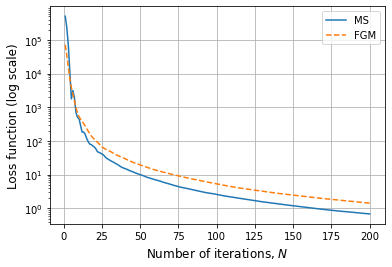

In [177]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.grid(True)
plt.plot(range(1, N1 + 1), plt1, label = 'MS', ls = '-')
plt.plot(range(1, N2 + 1), losses, label = 'FGM', ls = '--')
#plt.plot(range(1, N3 + 1), losses_c, label = 'FGM coord', ls = '-.')
plt.yscale('log')
plt.xlabel(r"Number of iterations, $N$", fontsize=12)
plt.ylabel(r"Loss function (log scale)", fontsize=12)
plt.legend()
plt.show()

In [178]:
#print(times_FG)
#print(times_MS)
print(plt1[-1], losses[-1])

0.6866924472349959 1.435717261992207


In [179]:
time_max = min(
    times_MS[-1] - times_MS[0],
    times_FG[-1] - times_FG[0]
)
ms_times_max_idx = np.searchsorted(np.array(times_MS) - times_MS[0], time_max, side="right")
fg_times_max_idx = np.searchsorted(np.array(times_FG) - times_FG[0], time_max, side="right")
print(time_max, ms_times_max_idx, fg_times_max_idx)

32.115283489227295 171 200


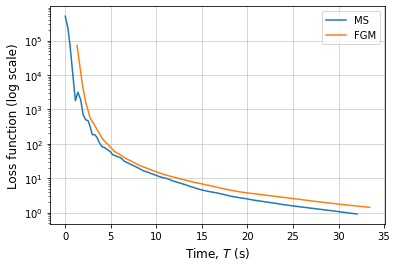

In [180]:
  %matplotlib inline
plt.semilogy((np.array(times_MS) - times_MS[0])[:ms_times_max_idx], (plt1)[:ms_times_max_idx], label="MS")
plt.semilogy(times_FG[:fg_times_max_idx], (losses)[:fg_times_max_idx], label="FGM")

plt.grid(linewidth=0.5)

plt.xlabel(r"Time, $T$ (s)", fontsize=12)
plt.ylabel(r"Loss function (log scale)", fontsize=12)
plt.legend()
plt.show()


In [181]:
#print(calls, calls_FG)
n_calls = np.cumsum(calls)
n_calls_FG = np.cumsum(calls_FG)
print(n_calls, n_calls_FG)

[   5366   10732   16098   21464   26830   32196   37562   42928   48294
   53660   59026   64392   69758   75124   80490   85856   91222   96588
  101954  107320  112686  118052  123418  128784  134150  139516  144882
  150248  155614  160980  166346  171712  177078  182444  187810  193176
  198542  203908  209274  214640  220006  225372  230738  236104  241470
  246836  252202  257568  262934  268300  273666  279032  284398  289764
  295130  300496  305862  311228  316594  321960  327326  332692  338058
  343424  348790  354156  359522  364888  370254  375620  380986  386352
  391718  397084  402450  407816  413182  418548  423914  429280  434646
  440012  445378  450744  456110  461476  466842  472208  477574  482940
  488306  493672  499038  504404  509770  515136  520502  525868  531234
  536600  541966  547332  552698  558064  563430  568796  574162  579528
  584894  590260  595626  600992  606358  611724  617090  622456  627822
  633188  638554  643920  649286  654652  660018  6

In [182]:
o_max = min(
    n_calls[-1],
    n_calls_FG[-1]
)
ms_idx = np.searchsorted(np.array(n_calls), o_max, side="right")
fg_idx = np.searchsorted(np.array(n_calls_FG), o_max, side="right")
print(o_max, ms_idx, fg_idx)

1072000 199 200


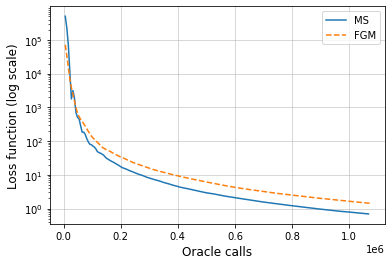

In [183]:
%matplotlib inline
plt.semilogy((np.array(n_calls))[:ms_idx], (plt1)[:ms_idx], label="MS", ls='-')
plt.semilogy(n_calls_FG[:fg_idx], (losses)[:fg_idx], label="FGM", ls = '--')

plt.grid(linewidth=0.5)

plt.xlabel(r"Oracle calls", fontsize=12)
plt.ylabel(r"Loss function (log scale)", fontsize=12)
plt.legend()
plt.show()
